# Transfer Learning

The learning goals of this tutorial are:

- Illustrate the transfer learning procedure using a model pre-trained on [ImageNet](http://www.image-net.org/).
- Get familiar with the Keras API to load pre-trained models and freeze layers during training.


1. Set up your data augmentation

2. Define your callbacks (save your model, patience, etc.)

3. Transfer Learning
    
    3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)
    
    3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model
    
    3.3. Add a top (i.e., the prediction layers)
    
    3.4  Train the model using your dataset
    
    3.5 Unfreeze the layers and fine-tune the whole model (i.e., train your model with a very small learning rate)
    
    3.6 If you are satisfied with the train and validation performance go to the next step
    
    3.7 If you are not satisfied with the train and validation performance go back to step 6.1.

4. Test your model on the test set and extract relevant metrics

In [14]:
import tensorflow as tf
import numpy as np
import glob
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Set up your data augmentation

In [41]:
def combine_channels(img1, img2, img3):
    full_list = []
    
    for ii in range(img1.shape[0]):
        lst = []
        
        lst.append(img1[ii]) #CT
        lst.append(img2[ii]) #Dose
        lst.append(img3[ii]) #CT+Dose
        
        lst_trans = np.array(lst).transpose()
        full_list.append(lst_trans)

    full_array = np.array(full_list)
    
    return full_array   

def scale_image(image, scale_type = 'min_max'):
    
    if scale_type == 'min_max':
        img_min = image.min()
        img_max = image.max()
        
        scaled_img = 255 * (image - img_min) / (img_max - img_min)
        
    return scaled_img

def split_features(X, indices): 
  train = int(0.7*indexes.size)
  val = int(0.85*indexes.size)

  Xtrain = X[:train]
  Xval = X[train:val]
  Xtest = X[val:]

  return Xtrain, Xval, Xtest


In [99]:
# # CT, Dose, CT+Dose
X = np.load('/content/sagittal_set_150.npy')
cor = np.load('/content/coronal_set_120.npy')
ax = np.load('/content/axial_set_130.npy')


# # CT Only
# X = np.load('/content/ct_sagittal_150.npy')
# X = combine_channels(X,X,X)
# print(X.shape)

# # Dose Only
# X = np.load('/content/dose_sagittal_150.npy')
# X = combine_channels(X,X,X)

print(X.shape)

#Y = np.load('/content/mdadi_labels_oh.npy')
Y = np.load('/content/mdadi_labels_binary_oh.npy')



(133, 300, 300, 3)


In [100]:
# Import pre-treatment factors
site = np.load('/content/cancer_site.npy', allow_pickle = True)
alcohol = np.load('/content/alcohol_intake.npy', allow_pickle = True)
smoking = np.load('/content/smoking_history.npy', allow_pickle = True)
n_stage = np.load('/content/n_stage.npy', allow_pickle = True)
t_stage = np.load('/content/t_stage.npy', allow_pickle = True)

# One hot encode variables
onehotencoder = OneHotEncoder()

site = onehotencoder.fit_transform(site.reshape(-1, 1)).toarray()
alcohol = onehotencoder.fit_transform(alcohol.reshape(-1,1)).toarray()
smoking = onehotencoder.fit_transform(smoking.reshape(-1, 1)).toarray()
n_stage = onehotencoder.fit_transform(n_stage.reshape(-1, 1)).toarray()
t_stage = onehotencoder.fit_transform(t_stage.reshape(-1, 1)).toarray()

print(site.shape, alcohol.shape, smoking.shape, n_stage.shape, t_stage.shape)

(133, 7) (133, 4) (133, 3) (133, 5) (133, 3)


In [101]:
bs = 64 # batch size

num_class = int(len(np.unique(Y)))
print(f'Number of classes: {num_class}')

indexes = np.arange(X.shape[0],dtype = int)
np.random.shuffle(indexes)
X = X[indexes]
Y = Y[indexes]

# Split the labels.
Ytrain, Yval, Ytest = split_features(Y, indexes)

# Split the images.
Xtrain, Xval, Xtest = split_features(X, indexes)
cor_train, cor_val, cor_test = split_features(cor, indexes)
ax_train, ax_val, ax_test = split_features(ax, indexes)

# Split the pre-treatment factors.
site_train, site_val, site_test = split_features(site, indexes)
alc_train, alc_val, alc_test = split_features(alcohol, indexes)
smo_train, smo_val, smo_test = split_features(smoking, indexes)
n_train, n_val, n_test = split_features(n_stage, indexes)
t_train, t_val, t_test = split_features(t_stage, indexes)

print(f'Training Set:')
print(f'Shape - {Xtrain.shape}')
print(f'Class Split - {np.bincount(Ytrain)}\n')

print(f'Validation Set:')
print(f'Shape - {Xval.shape}')
print(f'Class Split - {np.bincount(Yval)}\n')

print(f'Testing Set:')
print(f'Shape - {Xtest.shape}')
print(f'Class Split - {np.bincount(Ytest)}\n')

Number of classes: 2
Training Set:
Shape - (93, 300, 300, 3)
Class Split - [42 51]

Validation Set:
Shape - (20, 300, 300, 3)
Class Split - [ 9 11]

Testing Set:
Shape - (20, 300, 300, 3)
Class Split - [ 9 11]



## 2. Define your callbacks (save your model, patience, etc.)

In [102]:
model_name_it = "ct_classifier_en_b0_it.h5"
model_name_ft = "ct_classifier_en_b0_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 3. Transfer Learning

3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

3.3. Add a top (i.e., the prediction layers)

In [103]:
img_height = 300
img_width = 300

# Defining the base, pre-trained model.
# Load weights pre-trained on ImageNet.
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

# Defining the base, pre-trained model.
cor_base_model = tf.keras.applications.EfficientNetB1(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
cor_base_model.trainable = False

# Defining the base, pre-trained model.
ax_base_model = tf.keras.applications.EfficientNetB2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
ax_base_model.trainable = False

In [104]:
# Sagittal - load the model and flatten.
x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)

# Coronal - load the model, flatten and concatenate to sagittal.
cor_x1 = cor_base_model(cor_base_model.input, training = False)
cor_x2 = tf.keras.layers.Flatten()(cor_x1)
x_flat = tf.keras.layers.Concatenate(axis = 1)([x2, cor_x2])

# Axial - load the model, flatten and concatenate to sagittal and coronal.
ax_x1 = ax_base_model(ax_base_model.input, training = False)
ax_x2 = tf.keras.layers.Flatten()(ax_x1)
x_flat = tf.keras.layers.Concatenate(axis = 1)([x_flat, ax_x2])

In [105]:
x2 = x_flat

# Add pre-treatment features to flatten layer.
site_layer = tf.keras.layers.Input(shape = (site.shape[1],))
alcohol_layer = tf.keras.layers.Input(shape = (alcohol.shape[1],))
smoking_layer = tf.keras.layers.Input(shape = (smoking.shape[1],))
n_layer = tf.keras.layers.Input(shape = (n_stage.shape[1],))
t_layer = tf.keras.layers.Input(shape = (t_stage.shape[1],))

x3 = tf.keras.layers.Concatenate(axis=1)([x2, tf.keras.layers.Flatten()(site_layer)])
x4 = tf.keras.layers.Concatenate(axis=1)([x3, tf.keras.layers.Flatten()(alcohol_layer)])
x5 = tf.keras.layers.Concatenate(axis=1)([x4, tf.keras.layers.Flatten()(smoking_layer)])
x6 = tf.keras.layers.Concatenate(axis=1)([x5, tf.keras.layers.Flatten()(n_layer)])
x7 = tf.keras.layers.Concatenate(axis=1)([x6, tf.keras.layers.Flatten()(t_layer)])

In [106]:
# Combine the final model.
out = tf.keras.layers.Dense(num_class,activation = 'softmax')(x7)
model = tf.keras.Model(inputs = [base_model.input, cor_base_model.input, ax_base_model.input,\
                                 site_layer, alcohol_layer, smoking_layer, n_layer, t_layer], outputs = out)

print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_78 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 10, 10, 1280  4049571     ['input_77[0][0]']               
                                )                                   

## 3.4 Train the model using your dataset

In [107]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit([Xtrain, cor_train, ax_train , site_train, alc_train, smo_train, n_train, t_train], \
                       Ytrain, epochs= 10 , verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = ([Xval, cor_val, ax_val, site_val, alc_val, smo_val, n_val, t_val],Yval))

Epoch 1/10
3/3 [==============================] - 40s 7s/step - loss: 5.1582 - accuracy: 0.4624 - val_loss: 4.2866 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 4.7275 - accuracy: 0.5484 - val_loss: 4.1987 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 1.7213 - accuracy: 0.6667 - val_loss: 4.3126 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 1.8721 - accuracy: 0.6022 - val_loss: 0.9627 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.3957 - accuracy: 0.8710 - val_loss: 3.3072 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 0.8313 - accuracy: 0.8172 - val_loss: 1.5412 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 7/10
3/3 [==============================] - 3s 1s/step - loss: 0.0291

In [109]:
# Fine-tuning the model
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-7),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit([Xtrain, cor_train, ax_train , site_train, alc_train, smo_train, n_train, t_train],\
                       Ytrain, epochs= 2, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = ([Xval, site_val, alc_val, smo_val, n_val, t_val],Yval))


Fine-tuning model
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_78 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 10, 10, 1280  4049571     ['input_77[0][0]']               
                                )                                        

ResourceExhaustedError: ignored

## 4. Test your model on the test set and extract relevant metrics

In [111]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate([Xtest, cor_test, ax_test, site_test, alc_test, smo_test, n_test, t_test],Ytest)

# Testing the model in the fine tuning
# model = tf.keras.models.load_model(model_name_ft)
# model.evaluate([Xtest, site_test, alc_test, smo_test, n_test, t_test],Ytest)
# print(Ytest)

1/1 [==============================] - 7s 7s/step - loss: 1.0689 - accuracy: 0.7000


[1.0689160823822021, 0.699999988079071]

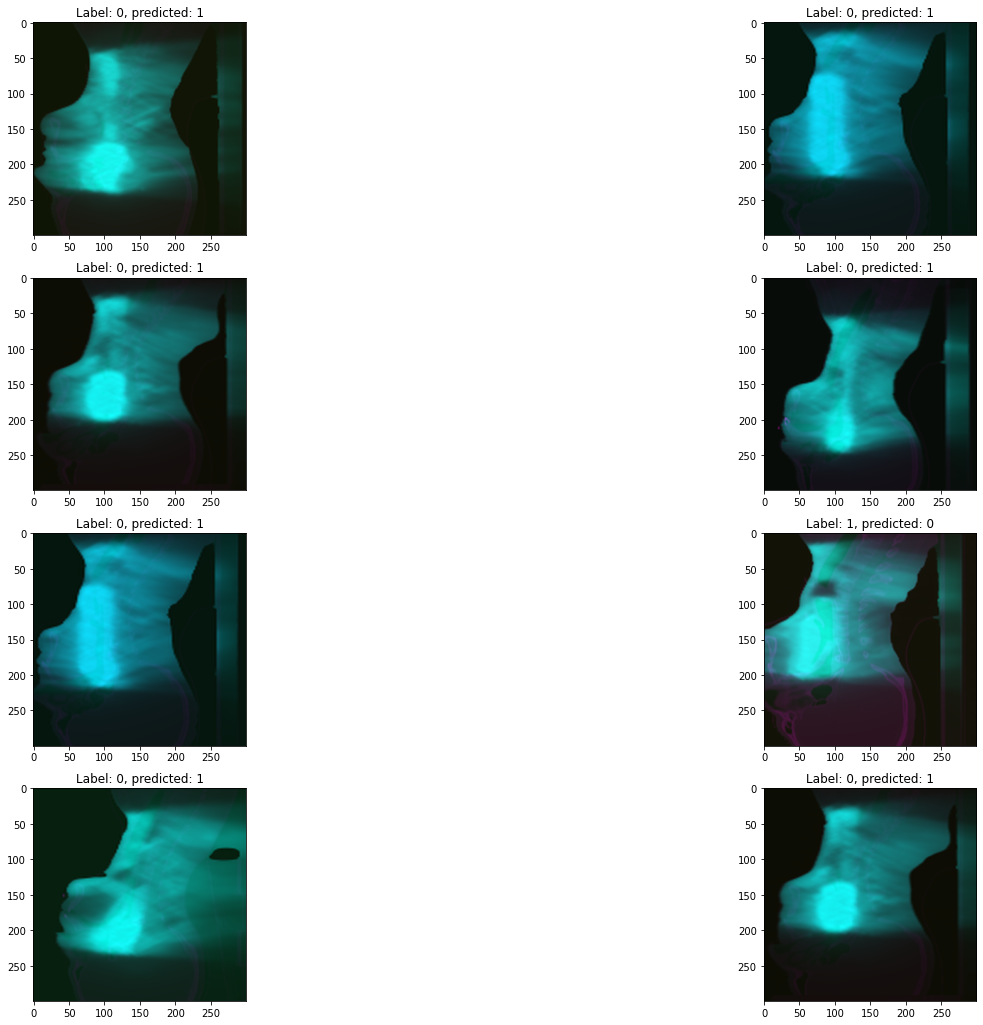

In [77]:
Ypred = model.predict([Xtest, site_test, alc_test, smo_test, n_test, t_test]).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = True)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Ytest[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()